[x] add solar zodi 

[ ] pick best example

[x] plot Bijan's curve?

## assumptions

* From OS6 readme
        "Each image is normalized to the total stellar 
      flux incident on the primary with only losses from the coronagraph masks 
      (without the masks the total flux would be 1.0 over an infinitely large 
      image)"
 **we'll assume this doesn't include  transmission and obscuration numbers**
* assume flat bands spectra in each band, not a black body. 


notes:

- binning decreases peak SNR for the face on disk
- SR is Bijan's SNR region which is a resel



In [1]:
import astropy.convolution as conv
import astropy.io.fits as fits
import astropy.units as u
import photutils
import astropy.constants as c

import os
import numpy as np
import poppy.utils
import poppy

import glob
from scipy.ndimage import rotate
from scipy.ndimage import shift

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.visualization import quantity_support
quantity_support()
%matplotlib inline

import importlib

plt.rcParams.update({'image.origin': 'lower',
                     'font.size': '12',
                     'image.interpolation':"nearest"})
import astropy
print("astropy version:",astropy.__version__.format())

import utils as utils_disk
from utils import displ_scale

my_home_dir = os.getcwd()
print(my_home_dir)

dQE= 0.695
losses=0.395#Bijan's "cumulative losses due to reflection and transmission w/ pupil obsc."

A = np.pi*(2.36/2*u.m)**2*losses*dQE
t_exp = 120*u.second
wavel = 550*u.nm ###################################################?
dlambda = wavel*0.1
E_phot=c.h*c.c/wavel/u.photon

gain=1*u.electron/u.photon #before electron multiplication 

#bijan's noise numbers:
dark_N_resel=2.4E-03*u.electron/u.second #electron/sec/resel
CIC_N_resel=8.2E-03*u.electron/u.second#clock induced electron/sec/resel
Lumines_N_resel=5.8E-04*u.electron/u.second#electron/sec/resel
read_N_resel=0.0E+00*u.electron/u.second#electron/sec/resel

EM_gain=5000*u.electron/u.electron #OS6 readme value

resel_d = ((575*u.nm)/(2.37*u.m)*u.radian).to(u.arcsec) #.048*u.arcsec #check where this came from
OS6_ps=21.1*u.milliarcsecond



KeyboardInterrupt: 

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

det_pixscale=0.021
halfpix = .5*det_pixscale


In [3]:
(c.h*c.c/wavel).to(u.eV)

<Quantity 2.15624691 eV>

In [2]:
debes_models = glob.glob(my_home_dir+"\DebesModels\*\**.fits",recursive = True) # collect the debes_models
debes_models.sort()
debes_models[1]

NameError: name 'glob' is not defined

From "README_os6_hlc_1.TXT":

    The bright reference star is eta UMa (V=1.8, B3V spectrum assumed)
    and the "science" target is 47 UMa (V=5.0, G0V spectrum assumed)
   
    ...
    os6_hlc_575nm_muf_images.fits
    os6_hlc_575nm_no_muf_images.fits
    --------------------------------
      Stack of exposures in 10% 575 nm filter with and without optical MUFs 
      applied. Photons/exptime appropriate to the star (exptime=120 sec), not
      including CCD QE.  No planets or detector noise have been added.  To 
      convert these images to contrast, divide by the total stellar flux 
      (phot/exptime/image) provided in the os6_timesteps.txt table for the 
      appropriate star and the divide by the PSF peak map.
      
      

Debes units are Janskys:

$d\nu=\frac{d\lambda}{\lambda^2}c$

$F_{Jy}$ [Watts/m^2/hz]

$f_\lambda$ [photons/m^2/nm]

$\frac{photons}{exp}=S_\nu \frac{c}{\lambda^2}d\lambda A t_{exp}$

In [5]:
#os6_hlc_575nm_no_muf_images.fits
hlc_dir = my_home_dir + "\offset_psfs\os6_hlc"
print(hlc_dir)

#mode = "muf_images"
#hlc = fits.open(hlc_dir+"os6_hlc_575nm_"+mode+".fits")[0].data*u.photon
#mode = "muf_planets_and_detector_noisy"
mode = "no_muf_planets_and_detector_noisy"
hlc = fits.open(hlc_dir+"\os6_hlc_575nm_"+mode+".fits")[0].data*u.electron

timesteps = np.genfromtxt(hlc_dir+"\os6_timesteps.txt", names=True)

#separate the science and reference stars
star1_ind = np.where(timesteps["star"] == 1) 
star2_ind = np.where(timesteps["star"] == 2)
n_exp_2 = np.size(star2_ind)
n_exp_1 = np.size(star1_ind)
star1_raw_unrot = np.sum(hlc[star1_ind[0],:,:], axis =0)#[0,:,:]
star2_raw_unrot = np.sum(hlc[star2_ind[0],:,:], axis = 0)#[0,:,:]
star1_phot_exp = timesteps['photonsexp'][star1_ind][0]
star2_phot_exp = timesteps['photonsexp'][star2_ind][0]
star1_raw_unrot.max()/star2_raw_unrot.max()
print(mode)

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\offset_psfs\os6_hlc
no_muf_planets_and_detector_noisy


In [6]:
timesteps["exptimes"][0]*n_exp_2/3600,hlc.shape[0]*120/3600


(95.33333333333333, 121.0)

In [7]:
roll= timesteps["roll"].copy()
pos_roll_ind=np.where(timesteps["roll"]  % 2 == 0)
neg_roll_ind=np.where(timesteps["roll"]  % 2 != 0)


star2_raw_neg_roll=rotate(np.sum(hlc[np.intersect1d(neg_roll_ind,star2_ind)],axis=0),-26,reshape=False)*hlc.unit
star2_raw_pos_roll=np.sum(hlc[np.intersect1d(pos_roll_ind,star2_ind)],axis=0)

star1_raw_neg_roll=rotate(np.sum(hlc[np.intersect1d(neg_roll_ind,star1_ind)],axis=0),-26,reshape=False)*hlc.unit
star1_raw_pos_roll=np.sum(hlc[np.intersect1d(pos_roll_ind,star1_ind)],axis=0)
print("check that most of the flux survived this chopping and rotating:")
print(np.sum(star2_raw_pos_roll+star2_raw_neg_roll)/star2_raw_unrot.sum())
star2_raw = (star2_raw_pos_roll+star2_raw_neg_roll)/EM_gain
print("check that most of the flux survived this chopping and rotating:")
print(np.sum(star1_raw_pos_roll+star1_raw_neg_roll)/star1_raw_unrot.sum())
star1_raw = (star1_raw_pos_roll+star1_raw_neg_roll)/EM_gain
star2=star2_raw #undo muliplication for noise purposes
star1=star1_raw #undo muliplication for noise purposes


check that most of the flux survived this chopping and rotating:
0.9363658420902262
check that most of the flux survived this chopping and rotating:
1.0


In [9]:
det_extent = ([-star2.shape[0]*det_pixscale/2-halfpix,
               +star2.shape[0]*det_pixscale/2-halfpix,
               -star2.shape[0]*det_pixscale/2-halfpix,
               +star2.shape[0]*det_pixscale/2-halfpix])

det_extent

[-1.5855000000000001,
 1.5645000000000002,
 -1.5855000000000001,
 1.5645000000000002]

In [8]:
core_maskedfile = my_home_dir + "\zodipics\zodipic_10pc03mas._coremasked_input.fits" 
fitsfile = debes_models[11]

fitsfile = my_home_dir + "\zodipics\zodipic_10pc03mas.fits_input.fits" 

outdir = my_home_dir + "\HLC_outputs"
print(outdir)

input_diskfits = fits.open(fitsfile)
print(fitsfile)

input_disk_flux=((input_diskfits[0].data.T
                 )*u.jansky*(c.c/wavel**2*dlambda)/E_phot).decompose()
input_disk_pho=(input_disk_flux*A*t_exp.decompose())

outfitsfile = outdir+fitsfile.split("/")[-1][:-4]+'_HLC.fits'
print(fits.getdata(outfitsfile))

disk_fits_array = np.abs(fits.open(outfitsfile)[0].data) #take abs so digital noise is positive
disk_flux = (disk_fits_array*u.jansky)*(c.c/wavel**2*dlambda)/E_phot

core_masked_outfitsfile = outdir+core_maskedfile.split("/")[-1][:-4]+'_HLC.fits'
core_masked_disk_fits_array = np.abs(fits.open(core_masked_outfitsfile)[0].data)
#take abs so digital noise is positive
core_masked_disk_flux = (core_masked_disk_fits_array*u.jansky)*(c.c/wavel**2*dlambda)/E_phot
print("max disk flux: {0:.3g}".format(disk_flux.max().decompose()))

input_core_masked_disk = np.abs(fits.open(core_maskedfile)[0].data)
#take abs so digital noise is positive
input_core_masked_disk_flux = (input_core_masked_disk*u.jansky)*(c.c/wavel**2*dlambda)/E_phot
#print(input_diskfits[0].header["alpha"])


C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\HLC_outputs
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics\zodipic_10pc03mas.fits_input.fits


OSError: [Errno 22] Invalid argument: 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\HLC_outputsC:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\zodipics\\zodipic_10pc03mas.fits_input._HLC.fits'

In [10]:
core_maskedfile2alpha = my_home_dir + "\zodipics\zodipic_10pc03mas02alpha._coremasked.fits" 
fitsfile2alpha = my_home_dir + "\zodipics\zodipic_10pc03mas02alpha.fits"

input_diskfits2alpha = fits.open(fitsfile2alpha)

input_disk_flux2alpha=((input_diskfits2alpha[0cf532a4q9 ].data.T
                 )*u.jansky*(c.c/wavel**2*dlambda)/E_phot).decompose()
input_disk_pho2alpha=(input_disk_flux2alpha*A*t_exp.decompose())

outfitsfile2alpha = outdir+fitsfile2alpha.split("/")[-1][:-4]+'_HLC.fits'
disk_fits_array2alpha = np.abs(fits.open(outfitsfile2alpha)[0].data) #take abs so digital noise is positive
disk_flux2alpha = (disk_fits_array2alpha*u.jansky)*(c.c/wavel**2*dlambda)/E_phot

core_masked_outfitsfile2alpha = outdir+core_maskedfile2alpha.split("/")[-1][:-4]+'_HLC.fits'
core_masked_disk_fits_array2alpha = np.abs(fits.open(core_masked_outfitsfile2alpha)[0].data)
#take abs so digital noise is positive
core_masked_disk_flux2alpha = (core_masked_disk_fits_array2alpha*u.jansky)*(c.c/wavel**2*dlambda)/E_phot
print("max disk flux: {0:.3g}".format(disk_flux2alpha.max().decompose()))


input_core_masked_disk2alpha = np.abs(fits.open(core_maskedfile2alpha)[0].data)
#take abs so digital noise is positive
input_core_masked_disk_flux2alpha = (input_core_masked_disk2alpha*u.jansky)*(c.c/wavel**2*dlambda)/E_phot
#print(input_diskfits[0].header["alpha"])



SyntaxError: invalid syntax (<ipython-input-10-271c51bcd922>, line 6)

In [ ]:
core_maskedfile1alpha = my_home_dir + "\zodipics\zodipic_10pc03mas01alpha_coremasked.fits" 
fitsfile1alpha = my_home_dir + "\zodipics\zodipic_10pc03mas01alpha.fits"" 

input_diskfits1alpha = fits.open(fitsfile1alpha)

input_disk_flux1alpha=((input_diskfits1alpha[0].data.T)*u.jansky*(c.c/wavel**2*dlambda)/E_phot).decompose()
input_disk_pho1alpha=(input_disk_flux1alpha*A*t_exp.decompose())

outfitsfile1alpha = outdir+fitsfile1alpha.split("/")[-1][:-4]+'_HLC.fits'
disk_fits_array1alpha = np.abs(fits.open(outfitsfile1alpha)[0].data) #take abs so digital noise is positive
disk_flux1alpha = (disk_fits_array1alpha*u.jansky)*(c.c/wavel**2*dlambda)/E_phot

core_masked_outfitsfile1alpha = outdir+core_maskedfile1alpha.split("/")[-1][:-4]+'_HLC.fits'
core_masked_disk_fits_array1alpha = np.abs(fits.open(core_masked_outfitsfile1alpha)[0].data)
#take abs so digital noise is positive
core_masked_disk_flux1alpha = (core_masked_disk_fits_array1alpha*u.jansky)*(c.c/wavel**2*dlambda)/E_phot
print("max disk flux: {0:.3g}".format(disk_flux1alpha.max().decompose()))


input_core_masked_disk1alpha = np.abs(fits.open(core_maskedfile1alpha)[0].data)
#take abs so digital noise is positive
input_core_masked_disk_flux2alpha = (input_core_masked_disk1alpha*u.jansky)*(c.c/wavel**2*dlambda)/E_phot
#print(input_diskfits[0].header["alpha"])




In [ ]:
core_maskedfile1alpha = my_home_dir + "\zodipics\zodipic_10pc03mas._coremasked_input.fits" 
fitsfile1alpha = my_home_dir + "\zodipics\zodipic_10pc03mas01alpha.fits"" 

input_diskfits1alpha = fits.open(fitsfile1alpha)

input_disk_flux1alpha=((input_diskfits1alpha[0].data.T)*u.jansky*(c.c/wavel**2*dlambda)/E_phot).decompose()
input_disk_pho1alpha=(input_disk_flux1alpha*A*t_exp.decompose())

outfitsfile1alpha = outdir+fitsfile1alpha.split("/")[-1][:-4]+'_HLC.fits'
disk_fits_array1alpha = np.abs(fits.open(outfitsfile1alpha)[0].data) #take abs so digital noise is positive
disk_flux1alpha = (disk_fits_array1alpha*u.jansky)*(c.c/wavel**2*dlambda)/E_phot

core_masked_outfitsfile1alpha = outdir+core_maskedfile1alpha.split("/")[-1][:-4]+'_HLC.fits'
core_masked_disk_fits_array1alpha = np.abs(fits.open(core_masked_outfitsfile1alpha)[0].data)
#take abs so digital noise is positive
core_masked_disk_flux1alpha = (core_masked_disk_fits_array1alpha*u.jansky)*(c.c/wavel**2*dlambda)/E_phot
print("max disk flux: {0:.3g}".format(disk_flux1alpha.max().decompose()))


input_core_masked_disk1alpha = np.abs(fits.open(core_maskedfile2alpha)[0].data)
#take abs so digital noise is positive
input_core_masked_disk_flux2alpha = (input_core_masked_disk2alpha*u.jansky)*(c.c/wavel**2*dlambda)/E_phot
#print(input_diskfits[0].header["alpha"])

In [ ]:
np.where(disk_flux2alpha==disk_flux2alpha.max())[0],disk_flux2alpha.max()

In [ ]:
plt.figure(figsize=[10,8])
#plt.plot(np.arange(-.005*100,.005*100,.005),disk_flux[100,:]/(+core_masked_disk_flux[100,:]),)

plt.plot(np.arange(-.005*100,.005*100,.005),disk_flux1alpha[100,:]/(+core_masked_disk_flux1alpha[100,:]),)

plt.plot(np.arange(-.005*100,.005*100,.005),disk_flux2alpha[100,:]/(+core_masked_disk_flux2alpha[100,:]),)

#plt.grid()
plt.xlabel(r"$^{\prime\prime}$",fontsize=26)
plt.text(.1,2.5,r"$p$=2",fontsize=26,color='orange')

plt.text(.1,1.01,r"$p$=1",fontsize=26,color='teal')

plt.ylabel("Flux Ratio",fontsize=26)

In [ ]:
local_zodi = fits.open("localzodi.fits")
local_zodi_hlc = fits.open(outdir+"localzodi._HLC.fits")
local_zodi_flux = (local_zodi_hlc[0].data[0,:,:]*u.jansky)*(c.c/wavel**2*dlambda)/E_phot
local_zodi_photons=(local_zodi_flux*A*t_exp).decompose()
print("max local zodi flux: {0:.3g}".format(local_zodi_flux.max().decompose()))
print("total local zodi photons per exposure:{0:.3g}".format(local_zodi_photons.sum().decompose()))

plt.imshow(local_zodi_hlc[0].data[0,:,:],extent=det_extent,norm=LogNorm(1e-12,1e-10))

plt.colorbar(label="Jy")
plt.title("Smooth local zodi background")
plt.savefig("WFIRST-CGI-DISKS-WRITE-UP/figs/smooth_local_zodi.pdf",bbox_inches="tight")

In [ ]:
importlib.reload(utils_disk)
#integrate for exposure time and telescope area:
disk_photons_total=(disk_flux*A*t_exp).decompose()

#resample to detector sampling and re-align by shifting 1 pixel
disk_photons=shift(utils_disk.apply_det(disk_photons_total,
                                        #ps_det=.0211*u.arcsecond/u.pixel,
                                        #ps_input=.005*u.arcsecond/u.pixel
                                       ),1)*disk_photons_total.unit

print("peak HLC  photons per observation: {0:.3g}".format(disk_photons.max().decompose()))

print("sum of HLC photons: {0:.3g}".format(disk_photons.sum()))

#calculate electrons per second on detector from local zodiacal light
local_zodi_photons=shift(utils_disk.apply_det(local_zodi_photons),1)*disk_photons.unit
local_zodi_elec_exp = (local_zodi_photons*gain).decompose()
print("peak local zodi HLC  photons : {0:.3g}".format(local_zodi_photons.max().decompose()))

star1 += local_zodi_elec_exp*n_exp_1 #local zodi is everywhere 
star2 += local_zodi_elec_exp*n_exp_2 #local zodi is everywhere

print("sum of HLC photons on detector: {0:.3g}".format(disk_photons.sum()))


20181124:
For Bijan's model, 3500 e- corresponds to SNR=12 and an magnitude sensitivity of 20 mags/sq^2

We are assuming 

In [ ]:
importlib.reload(utils_disk)
PSF_area = 2.3E-03*u.arcsec**2 #bijan's spreadsheet, 92% of the ideal:  (575*u.nm/(2.37*u.m)*u.radian)**2
n_pix_per_resel = PSF_area/(OS6_ps)**2
resel_sampled_array = utils_disk.apply_det(disk_photons_total,#det_shape=None,
                                           ps_det=resel_d,#(575*u.nm/(2.37*u.m)*u.radian)
                                          )

#print("peak HLC  electrons per simulation pixel: {0:.3g}".format((disk_photons.max()*gain).decompose()))

print("independently estimate electrons per resel")
print("peak  HLC disk electrons per ideal resel, calculated: {0:.4g}".format((disk_photons.max()*gain*n_pix_per_resel).decompose()))
print("peak  HLC disk electrons per ideal resel, zoomed: {0:.4g}".format((resel_sampled_array.max()*gain).decompose()))
print("peak HLC Local ZODI electrons per ideal resel, zoomed: {0:.4g}".format((np.max(local_zodi_photons)*gain).decompose()))



In [ ]:
t_obs = n_exp_2*t_exp
detector_N = np.sqrt((dark_N_resel*t_obs/n_pix_per_resel)**2
                     + (CIC_N_resel*t_obs/n_pix_per_resel)**2 
                     + (Lumines_N_resel*t_obs/n_pix_per_resel)**2)
t_obs.to(u.hour),detector_N.decompose()
det_N_array=np.random.normal(loc=0.0, scale=detector_N.to(u.electron).value, size=star1_raw.shape)
plt.imshow(det_N_array,)
plt.colorbar()
plt.figure()


NameError: name 'input_disk_flux' is not defined

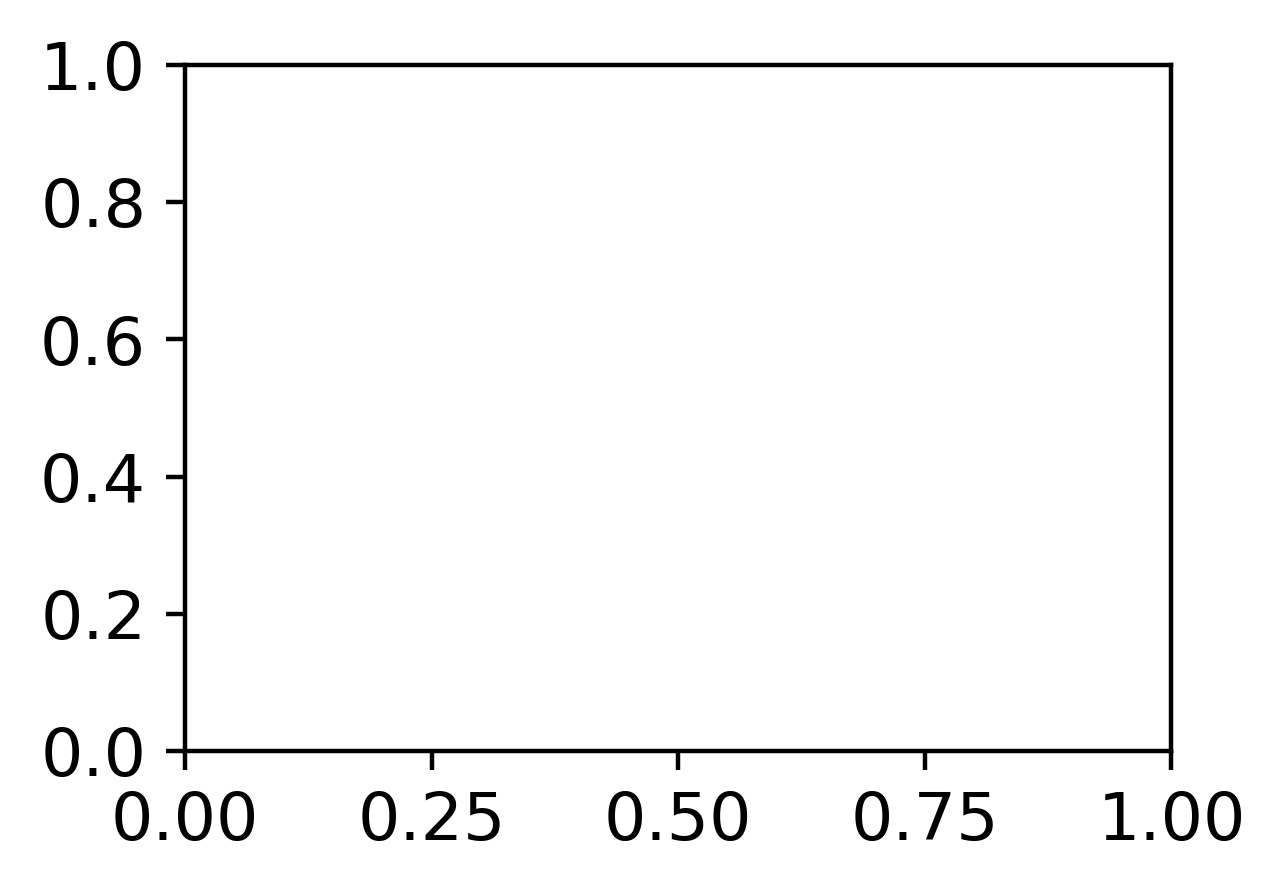

In [7]:
plt.figure(figsize=[7,5],dpi=400)
#plt.title("Input Flux")
ax=plt.subplot(222)
displ_scale(input_disk_flux,3*u.milliarcsecond,cmap=plt.cm.viridis,
                       #vmax=1e-18,#input_disk_flux.decompose().value.max(),
                      # vmax=.1,#e-18,#input_disk_flux.decompose().value.max(),
           #vmin=1e-25,
            norm=LogNorm())
plt.xlim([-.5,.5])
plt.ylim([-.5,.5])
plt.title("Input Zodi")
ax.xaxis.set_visible(False)#=[""]
ax.yaxis.set_visible(False)#=[""]

ax=plt.subplot(221)
plt.title("IWA Truncated Input Zodi")
plt.ylabel(r"$^{\prime\prime}$")

displ_scale(input_core_masked_disk_flux,
            3*u.milliarcsecond,cmap=plt.cm.viridis,
            norm=LogNorm(),
           #vmax=.1,#e-18,#input_disk_flux.decompose().value.max(),
           #min=1e-25,


           #vmin=input_disk_flux.decompose().value.min()
           )
plt.xlim([-.5,.5])
plt.ylim([-.5,.5])
ax.xaxis.set_visible(False)#=[""]

ax=plt.subplot(224)

det_samp_disk_flux=shift(utils_disk.apply_det(disk_flux.decompose(),
                                        #ps_det=.0211*u.arcsecond/u.pixel,
                                        #ps_input=.005*u.arcsecond/u.pixel
                                             ),
                         0)*disk_flux.decompose().unit

displ_scale(det_samp_disk_flux,
            21*u.milliarcsecond,cmap=plt.cm.plasma)

plt.xlim([-.5,.5])

plt.ylim([-.5,.5])
#ax.xaxis.set_visible(False)#=[""]

ax.yaxis.set_visible(False)#=[""]

ax=plt.subplot(223)
displ_scale(shift(utils_disk.apply_det(core_masked_disk_flux.decompose(),
                                        #ps_det=.0211*u.arcsecond/u.pixel,
                                        #ps_input=.005*u.arcsecond/u.pixel
                                      ),
                  0)*det_samp_disk_flux.unit,
            21*u.milliarcsecond,
            vmax=det_samp_disk_flux.decompose().value.max(),
            cmap=plt.cm.plasma
           )

plt.xlim([-.5,.5])
#ax.xaxis.set_visible(False)#=[""]
plt.ylim([-.5,.5])
plt.ylabel(r"$^{\prime\prime}$")

plt.tight_layout(0)

In [ ]:
plt.figure(figsize=[20,5])
from astropy import visualization
visualization.quantity_support()
plt.subplot(131)
plt.title("Input Flux")
displ_scale(disk_photons_total,0.005*u.arcsec,cmap=plt.cm.plasma)
plt.xlim([-.5,.5])

plt.ylim([-.5,.5])

plt.subplot(132)
plt.title("detector sampling")
displ_scale(disk_photons,21*u.milliarcsecond,cmap=plt.cm.plasma)
plt.xlim([-.5,.5])

plt.ylim([-.5,.5])

plt.subplot(133)
plt.title("resel sampling")
displ_scale(resel_sampled_array,resel_d,cmap=plt.cm.plasma)
plt.xlim([-.5,.5])

plt.ylim([-.5,.5])
plt.tight_layout()
plt.savefig("WFIRST-CGI-DISKS-WRITE-UP/figs/"+fitsfile.split("/")[-1][:-5]+'_reselsHLC.png')


In [ ]:

plt.title("resel sampling electrons per obs")
displ_scale((resel_sampled_array*t_exp*n_exp_2).decompose(),resel_d)
plt.xlim([-.5,.5])

plt.ylim([-.5,.5])


In [ ]:
#plt.imshow(utils_disk.add_poisson_noise(disk_photons.decompose().value[disk_photons>0] ).reshape(150,150))
disk_photons.shape

In [ ]:

plt.figure(figsize=[13,3.5])
plt.subplot(131)

plt.imshow(input_disk_pho.decompose().value)
plt.title(str(input_disk_pho.unit) +" per \n"+fitsfile.split("/")[-1].replace(".fits",""),fontsize=10)

plt.colorbar()


plt.subplot(132)
plt.imshow(disk_fits_array)
plt.title("Janskys \n"+fitsfile.split("/")[-1].replace(".fits",""),fontsize=10)
plt.colorbar()
plt.subplot(133)
plt.imshow(((disk_photons.decompose().value )))
plt.title(str(disk_photons.unit)+" per  \n"+outfitsfile.split("/")[-1].replace(".fits",""),fontsize=10)
plt.colorbar()
#plt.tight_layout()
plt.savefig("WFIRST-CGI-DISKS-WRITE-UP/figs/"+fitsfile.split("/")[-1][:-5]+'_HLC.png')

#plt.figure()
#plt.imshow(local_zodi_photons.value)
#lt.title(str(local_zodi_photons.unit))

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\offset_psfs\os6_hlc


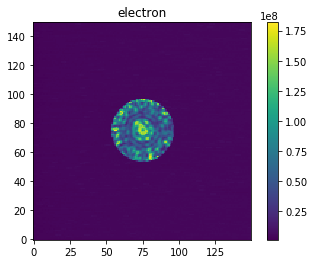

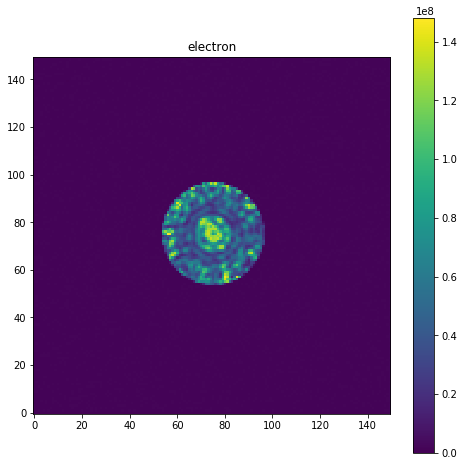

In [11]:
print(hlc_dir)

noiseless = fits.getdata(hlc_dir + "\\" + "os6_hlc_575nm_muf_planets_and_detector_noiseless.fits")*u.photon
noisy = fits.getdata(hlc_dir + "\\" + "os6_hlc_575nm_muf_planets_and_detector_noisy.fits")*u.electron
plt.imshow(np.sum(noisy,axis=0).value)
plt.title("{}".format(noisy.unit))

noiseless_star2 = gain*np.sum(noiseless[star2_ind],axis=0)
noiseless_star1 = gain*np.sum(noiseless[star1_ind],axis=0)

plt.colorbar()
plt.figure(figsize=[8,8])
det_noise_star1=np.sum(noisy[star1_ind],axis=0)-noiseless_star1
det_noise_star2=np.sum(noisy[star2_ind],axis=0)-noiseless_star2

plt.imshow(det_noise_star1.value,vmin=0)
plt.title("{}".format(det_noise_star1.unit))
plt.colorbar()


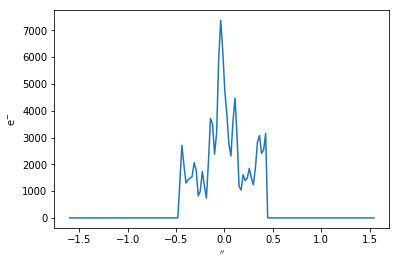

In [8]:
#check plate scale looking at cross section, should be 0.5 arcsec OWA, or 1 arcsec diameter FOV.
plt.plot(np.arange(150)*.0211*u.arcsec-1.6*u.arcsecond,noiseless_star2[:,77])
#(10*575*u.nm/(2.37*u.m)*u.radian).to(u.arcsecond)

Show that the input disk Janskies: are consistent with 22 mags/arcsecond^2

In [16]:
#consistency check of unit conversion with pysynphot
import pysynphot as S
mag = 22.00 #abmag
wavel = 575 #nm
sp = S.ArraySpectrum(wave=np.array([wavel]),
                     flux=np.array([mag]),
                     waveunits='nm', 
                     fluxunits='abmag',)
sp.convert("photlam") #photons/angstrom/cm^2/s
#to(u.photon/u.angstrom/u.cm**2/u.s)#.decompose()
sp.convert("Jy") #photons/angstrom/cm^2/s
print("{} mag/as^2 at {} nm {}  [Jy/pix]".format(mag,wavel,(sp.flux[0])*.003**2))#to(u.photon/u.angstrom/u.cm**2/u.s)#.decompose()
print("John's disk max:  %2.2g [Jy/pix]:"%(input_diskfits[0].data.max()))


ModuleNotFoundError: No module named 'pysynphot'

Check zero-mag flux, spreadsheet has 5.81e9phot/m^2/s for G0V at 575

In [ ]:

#check zero
spZero = S.ArraySpectrum(wave=np.array([575]),flux=np.array([0]),
                     waveunits='nm', 
                     fluxunits='abmag',)
spZero.convert("photlam") #photons/angstrom/cm^2/s
print(" {0:.6e}".format(spZero.flux[0]*(u.photon/u.angstrom/u.cm**2/u.s*dlambda).decompose()))



In [ ]:
#Check John's V=22 mag/sq "? 
zeroP = 948*u.photon/u.cm**2/u.second/u.angstrom
F = zeroP*10**(-(22)/2.5)/u.arcsecond**2*(.003*u.arcsecond)**2 
print(" {0:.6e}".format(sp.flux[0]*(u.photon/u.angstrom/u.cm**2/u.s*dlambda).decompose()*.003**2))

print(" {0:.6e}".format((F*dlambda).decompose()))


## Check noise levels

11/24/2018 - Bijan's model gives **3118-4000 (or 4096) electrons of total noise** for the nominal case,  if residual speckles are set to the speckle brightness. This is consistent with the sqrt of the total noise in star, shown below.


NameError: name 'star1_raw' is not defined

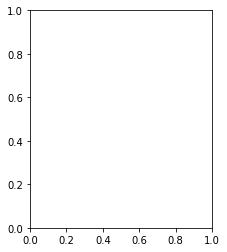

In [9]:
lim=.4

plt.figure(figsize=[15,4])
plt.subplot(141)
plt.imshow(star1_raw.value,extent=det_extent)
plt.title(r"$\eta$ uma,{}".format(star1.unit))

plt.colorbar()
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])
plt.subplot(142)
plt.imshow(star2_raw.value,extent=det_extent)
plt.colorbar()

cs=plt.contour((star2_raw.value),
               extent=det_extent,
               levels=[2000],
               colors="black")

plt.title(star2.unit)
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

plt.title("47 uma,{}".format(star2.unit))

plt.subplot(143)

plt.imshow((star2_raw/np.max(star2_raw)).value-(star1_raw/np.max(star1_raw)).value,
           extent=det_extent)
plt.colorbar()
plt.title("normalized diff")
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

plt.subplot(144)
plt.imshow(np.sqrt(star1_raw.value),extent=det_extent)
plt.colorbar()
plt.clabel(cs, inline=True, fontsize=10)

plt.title(star2.unit)
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])
plt.title(r"$\sqrt{47uma [e^-]}$")
plt.tight_layout()


In [ ]:
n = disk_photons.shape[0]

In [ ]:
star2_err = np.sqrt(np.sum(star2))
star1=star1
z_range=[50,300]
excess=np.zeros(len(z_range))*u.electron
for i,z in enumerate(z_range):
    disk_phot_z= (z*disk_photons*n_exp_2*gain).decompose()
    star2_dusty = star2 + disk_phot_z#utils_disk.add_poisson_noise()
    surfbright=np.round(22-2.5*np.log10(z/1),2)

    #star1_noisy= utils.add_poisson_noise(star1)
    excess[i]=disk_phot_z.sum()
    
    plt.figure(figsize=[8,6])    
    plt.subplot(221)

    plt.title(fitsfile.split("/")[-1]
              +"\n disk [{}]".format(input_disk_pho.unit))
    plt.imshow(input_disk_pho.value,interpolation='nearest',norm=LogNorm(),
              cmap=plt.cm.magma)
    plt.colorbar(label="photons/obs")
    #plt.xlim([50,100])
    #plt.ylim([50,100])
    
    plt.subplot(222)

    plt.title("HLC disk [{}]".format(disk_phot_z.unit))
    plt.imshow(disk_phot_z.value,
               extent=det_extent,
               interpolation='nearest',)
    plt.xlim([-lim,lim])
    plt.ylim([-lim,lim])
    plt.colorbar(label="photons/obs")

    plt.subplot(223)
    plt.imshow(star2_dusty.value,
               extent=det_extent,
               interpolation='nearest',)
    plt.xlim([-lim,lim])
    plt.ylim([-lim,lim])
    plt.colorbar(label=star2_dusty.unit)
    plt.title("47 Uma + disk, [{}]".format(star2_dusty.unit))
    plt.xlabel(r"$\prime\prime$")


    plt.subplot(224)
    
    plt.imshow((star2_dusty/np.max(star2_dusty[76,76])-star1/star1[76,76]).value,
               extent=det_extent,interpolation='nearest')
    plt.xlim([-lim,lim])
    plt.ylim([-lim,lim])
    plt.xlabel(r"$\prime\prime$")

    #plt.colorbar()
    plt.title(" 47 Uma - $\eta$-Uma, n$_z$= {}".format(z))
    plt.colorbar(label="normalized diff")
    plt.tight_layout()

    plt.savefig("WFIRST-CGI-DISKS-WRITE-UP/figs/"+fitsfile.split("/")[-1]+mode+"_{}z".format(z)+".png",
                bbox_inches="tight")
    plt.suptitle("{} mag/sq$^2$".format(surfbright))

    plt.figure(figsize=[14,4])
    plt.subplot(131)
    
    plt.title("Disk e$^-$ per resel per obs")
    binned_disk_phot_z = utils_disk.apply_det(disk_phot_z,
                               ps_input= det_pixscale*u.arcsec,
                               det_shape=None,#(50,50),
                               ps_det=resel_d).to(u.electron).value
    N= np.sqrt((star2.to(u.electron)**2).value+star2_dusty.to(u.electron).value)*u.electron
    binned_N =  utils_disk.apply_det(N,
                                     ps_input= det_pixscale*u.arcsec,
                                     det_shape=None,#(50,50),
                                     ps_det=resel_d)
    displ_scale(binned_disk_phot_z,ps=resel_d)
    plt.xlim([-.5,.5])

    plt.ylim([-.5,.5])
    plt.subplot(132)
    #SNR including photon noise from disk:
    SNR=(disk_phot_z/N).decompose()
    print("N >2sigma {}".format(np.size(np.where(SNR>2))))
    plt.imshow(SNR.value,cmap=plt.cm.gnuplot,extent=det_extent,interpolation='nearest')
    plt.colorbar()
    boxcar=2
    CS=plt.contour(conv.convolve_fft(SNR,conv.Box2DKernel(boxcar)), [1,2,3,5,10,20],extent=det_extent,colors="yellow")
    plt.xlim([-lim,lim])
    plt.ylim([-lim,lim])
    plt.clabel(CS, inline=False, fontsize=10,inline_spacing=2)
    plt.title("SNR, no processing, n$_z$= {}, ({:0.2g}) \n".format(z,t_exp.to(u.hour)*n_exp_2)+fitsfile.split("/")[-1]+"\n"r"Contours: {}$\times${} boxcar".format(boxcar,boxcar))
    plt.subplot(133)
    #SNR including photon noise from disk:
    plt.imshow((binned_disk_phot_z/binned_N).decompose().value,cmap=plt.cm.gnuplot,extent=det_extent)
    print("peak of {} disk electrons per resel for {} zodi({} mag/as^2)".format(np.max(binned_disk_phot_z),
                                                                                z,
                                                                                surfbright))

    plt.colorbar()
    boxcar=2
    CS=plt.contour(conv.convolve_fft(SNR,conv.Box2DKernel(boxcar)), [1,2,3,5,10,20],extent=det_extent,colors="yellow")

    plt.xlim([-lim,lim])
    plt.ylim([-lim,lim])
    plt.clabel(CS, inline=False, fontsize=10,inline_spacing=2)
    plt.title("SNR, binned resels")
    plt.savefig("WFIRST-CGI-DISKS-WRITE-UP/figs/"+fitsfile.split("/")[-1]+mode+"_{}z".format(z)+"SNR.png",
                bbox_inches="tight")



Bijan's model predicts 23 magnitudes/as^2 at 5 sigma:
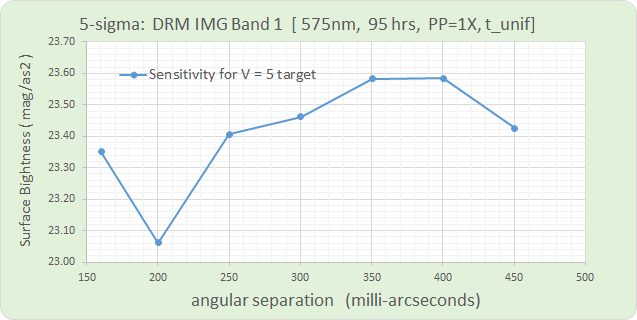
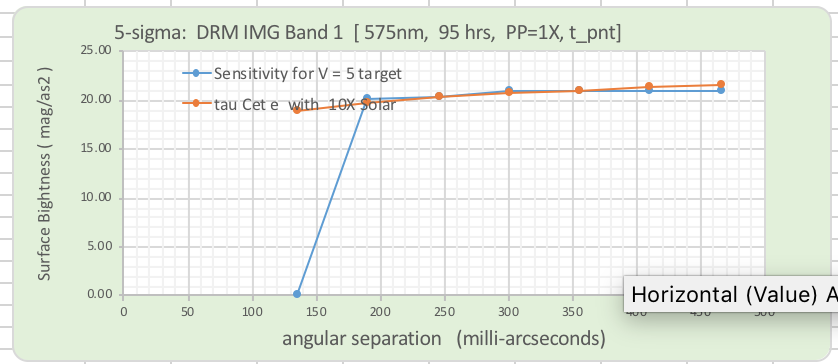


In [ ]:
plt.figure()
plt.imshow(star2_dusty/star2,
               cmap=plt.cm.gnuplot,extent=det_extent)

CS = plt.contour(SNR,extent=det_extent)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Simplest default with labels')
disk_phot_z.unit


In [ ]:
plt.figure()
ax=plt.subplot(111)
N=np.sqrt(excess.value
          +star2.to(u.electron).sum().value
          +star1.to(u.electron).sum().value)
N_det=np.sqrt(excess.value
              +det_noise_star2.to(u.electron).sum().value
              +det_noise_star1.to(u.electron).sum().value)
f_pp=1#0.5
N_sys= f_pp*np.sqrt(noiseless_star2**2).mean()

peak=(disk_photons.max()*z_range*n_exp_2*gain).decompose()

N_peak=N_sys.value+np.sqrt(N_sys+
               +det_noise_star2.to(u.electron).max()
               +det_noise_star1.to(u.electron).max()).value
plt.plot(z_range,peak.value/N_peak,'-x',label="Brightest Pixel ({:0.2g})".format(t_exp.to(u.hour)*n_exp_2))#,fmt=".",markersize=10,color="gray")


print(peak/np.median(N_peak))


SNR_frame=(peak.value/n_exp_1)/ \
            np.sqrt((N_sys+peak).value/n_exp_2+
                    det_noise_star2.to(u.electron).max().value/n_exp_1
                    +det_noise_star1.to(u.electron).max().value/n_exp_1)
frac_2hr=2*u.hour/(t_exp.to(u.hour)*n_exp_2)

SNR_2hrs=(peak.value*frac_2hr)/ \
            np.sqrt((N_sys+peak).value*frac_2hr+
                    det_noise_star2.to(u.electron).max().value*frac_2hr
                    +det_noise_star1.to(u.electron).max().value*frac_2hr)


#plt.errorbar(0,np.sum(star2).value,yerr=star2_err.value,fmt=".",markersize=10)
#plt.plot(z_range,excess.value/N,'-.',label="Photon noise")#,fmt=".",markersize=10,color="gray")
plt.plot(z_range,excess.value/N_det,'-.',label="Excess in Full Image ({:0.2g})".format(t_exp.to(u.hour)*n_exp_2))#,fmt=".",markersize=10,color="gray")

plt.plot(z_range,SNR_2hrs,'-',label="Brightest Pixel, (2 hrs)  ")#,fmt=".",markersize=10,color="gray")
plt.plot(z_range,SNR_frame,'-',label="Brightest Pixel, Single Frame ({})".format(t_exp))#,fmt=".",markersize=10,color="gray")


plt.ylabel("SNR")
plt.xlabel("$n_{zodi}$")
plt.legend()
plt.yscale("log")
plt.title(mode)
#plt.xlim([1e-5,10])
plt.xscale("log")
#lt.ylim([1,10000])
#plt.yscale("log")
ax.set_yticks([1,5,100,1000,1e4])
import matplotlib.ticker
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.grid()

plt.savefig("WFIRST-CGI-DISKS-WRITE-UP/figs/"+fitsfile.split("/")[-1]+"SNR.pdf",bbox_inches="tight")

In [17]:
peak=(disk_photons.max()*z_range*n_exp_2*gain).decompose()


NameError: name 'disk_photons' is not defined

In [ ]:
#per pixel?

SNR_frame=(peak.value/n_exp_1)/np.sqrt(peak.value+det_noise_star2.to(u.electron).max().value/n_exp_1+det_noise_star1.to(u.electron).max().value/n_exp_1)
print(SNR_frame,t_exp.to(u.hour)*n_exp_2)

In [ ]:
plt.figure(figsize=[4,3])
contrast_map=star2/star2_phot_exp
contrast_map_dusty=star2_dusty/star2_phot_exp

contrast_fits=fits.HDUList([fits.PrimaryHDU(contrast_map)])
contrast_fits[0].header["PIXELSCL"]= 0.005
radial=poppy.utils.radial_profile(contrast_fits)
radial_err=poppy.utils.radial_profile(contrast_fits,stddev=True)
plt.errorbar(radial[0],radial[1],yerr=radial_err[1],label="Dustless RDI",fmt="--",alpha=.7)

contrast_fits_dusty=fits.HDUList([fits.PrimaryHDU(contrast_map_dusty)])
contrast_fits_dusty[0].header["PIXELSCL"]= 0.005
radial_dusty=poppy.utils.radial_profile(contrast_fits_dusty)
radial_err_dusty=poppy.utils.radial_profile(contrast_fits_dusty,stddev=True)
plt.errorbar(radial_dusty[0],radial_dusty[1],yerr=radial_err_dusty[1],label="Dusty RDI",alpha=.7)

plt.ylabel("$F_{pix}/F_{star}$")
plt.xlim([0,.5])
plt.legend()
plt.title("zodi=%.2g"%(z))
plt.xlabel("arcsecond")

In [ ]:
#consistency check of unit conversion with pysynphot
import pysynphot as S
sp = S.ArraySpectrum(wave=np.array([575]),flux=np.array([disk_fits_array.max()]),
                     waveunits='nm', 
                     fluxunits='Jy',)
sp.convert("photlam") #photons/angstrom/cm^2/s
(sp.flux*(u.photon/u.angstrom/u.cm**2/u.s)*dlambda).decompose()

In [ ]:
fitsfile="zodipic0.5.fits"
zodi_fits = fits.open(fitsfile)
input_data=zodi_fits[0].data
outfitsfile=fits.open("output/"+fitsfile.split("/")[-1][:-4]+'_HLC.fits')
disk=outfitsfile[0].data
outpix=input_data.shape

input_array=input_data[int(outpix[0]/2-100):int(outpix[0]/2+100),
                                 int(outpix[1]/2-100):int(outpix[1]/2+100)]
plt.imshow(np.log10(input_array))
plt.colorbar()

In [ ]:
plt.imshow(disk/input_array)
plt.colorbar()
plt.title("fractional zodi light")

In [ ]:
frac_2hr

In [ ]:
star2.to(u.electron)

In [ ]:
#Nemati texp
#resolution
D=240*u.cm
wavel=575*u.nm
resel=(wavel/D*u.radian).to(u.arcsec)**2

QE=.9*u.electron/u.photon
bw=50*u.nanometer
thruplanet=.2
A=np.pi*(D/2)**2

m=3
F=948*u.photon/(u.Angstrom*u.cm**2*u.second)*10**(-m/2.5)
fratio=1e-9
R=5
thrustar=.1
C_CGI= 1e-10
rpl= F*bw*fratio*A*thruplanet*QE
rn=rpl
ksz=1.3
kd=1.2
mag_solar_zodi=22.0
rzo=(948*u.photon/(u.Angstrom*u.cm**2*u.second)*10**(-mag_solar_zodi/2.5)*u.arcsecond**2/resel*bw*A).decompose()*QE

mpix=4
fpp=.01#.1
rsp= F*bw*C_CGI*A*thrustar*QE
rdet=0.0*u.electron/u.second #conservative(Exo-C is assumed 0.0005 e−/sec)
rn=rpl+ksz*(rsp+rzo)+kd*rdet
tR=R**2*rn/(rpl**2-R**2*fpp*rsp**2)*u.electron 
#extra electron because of denominator of SNR
tR=np.round(tR.decompose().to(u.hour),0)
tR

In [17]:
#pysynphot bug report for unexpected 0-mag v-band behavior 
#https://github.com/spacetelescope/pysynphot/issues/100
import pysynphot as S
sp = S.ArraySpectrum(wave=np.array([5510]),flux=np.array([0]),
                     fluxunits='vegamag',)
print([sp.flux,sp.fluxunits.name])


sp.convert("photlam") #photons/angstrom/cm^2/s
print([sp.flux,sp.fluxunits.name])

sp = S.ArraySpectrum(wave=np.array([5510]),flux=np.array([0]),
                     fluxunits='abmag',)
print([sp.flux,sp.fluxunits.name])

sp.convert("photlam") #photons/angstrom/cm^2/s
print([sp.flux,sp.fluxunits.name])

print(S.__version__)

ModuleNotFoundError: No module named 'pysynphot'

In [ ]:
    plt.suptitle("{} mag/sq$^2$".format(np.round(22-2.5*np.log10(z/1),2)))

    displ_scale(utils_disk.apply_det(disk_phot_z,
                               ps_input= .021*u.arcsec,
                               det_shape=None,#(50,50),
                               ps_det=resel_d),ps=resel_d)
